## This notebook shows the near-enhancer and enhancing active enhancer experiments.
#### Luciferase values are in ./data/enhance_rescue/luciferase folder
#### Figures are saved to ./figures/enhance_rescue folder

### General imports

In [1]:
import sys  
import os
import pickle
import utils
import numpy as np
import scipy
import tensorflow as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading DeepMEL2 data to be used for the initialization of shap.DeepExplainer

In [2]:
print('Loading data...')
f = open('./data/deepmel2/DeepMEL2_nonAugmented_data.pkl', "rb")
nonAugmented_data_dict = pickle.load(f)
f.close()

Loading data...


### Loading the models and initializing shap.DeepExplainer

In [3]:
print('Loading model...')
import shap
tf.disable_eager_execution()
rn=np.random.choice(nonAugmented_data_dict["train_data"].shape[0], 250, replace=False)
model_dict = {}
exp_dict = {} 

name = "deepmel2"
model_json_file = "models/deepmel2/model.json"
model_hdf5_file = "models/deepmel2/model_epoch_07.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), [nonAugmented_data_dict["train_data"][rn],nonAugmented_data_dict["train_data"][rn][:,::-1,::-1]])


name = "deepmel2_gabpa"
model_json_file = "models/deepmel2_gabpa/model.json"
model_hdf5_file = "models/deepmel2_gabpa/model_epoch_09.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), [nonAugmented_data_dict["train_data"][rn],nonAugmented_data_dict["train_data"][rn][:,::-1,::-1]])


name = "deepmel"
model_json_file = "models/deepmel/model.json"
model_hdf5_file = "models/deepmel/model_best_loss.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), [nonAugmented_data_dict["train_data"][rn],nonAugmented_data_dict["train_data"][rn][:,::-1,::-1]])


Loading model...


In [4]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

### Loading fasta file and calculating prediction scores

In [5]:
resc_X, resc_id = utils.prepare_data("data/enhance_rescue/regions.fa")
rescue_dict = {}
rescue_dict["X"] = resc_X
rescue_dict["ids"] = resc_id
rescue_dict["prediction_deepmel"] = model_dict["deepmel"].predict([rescue_dict["X"],rescue_dict["X"][:,::-1,::-1]])
rescue_dict["prediction_deepmel2"] = model_dict["deepmel2"].predict([rescue_dict["X"],rescue_dict["X"][:,::-1,::-1]])
rescue_dict["prediction_deepmel2_g"] = model_dict["deepmel2_gabpa"].predict([rescue_dict["X"],rescue_dict["X"][:,::-1,::-1]])

### Loading luciferase results

In [6]:
rescue_dict["values"] = []
with open("data/enhance_rescue/luciferase.txt","r") as fr:
    for line in fr:
        if line.startswith("id"):
            continue
        sep = line.strip().split("\t")
        rescue_dict["values"].append(sep[1:])
rescue_dict["values"] = np.array(rescue_dict["values"],dtype="float")

### Plotting luciferase values versus prediction scores for the rescue of near-enhancer sequence

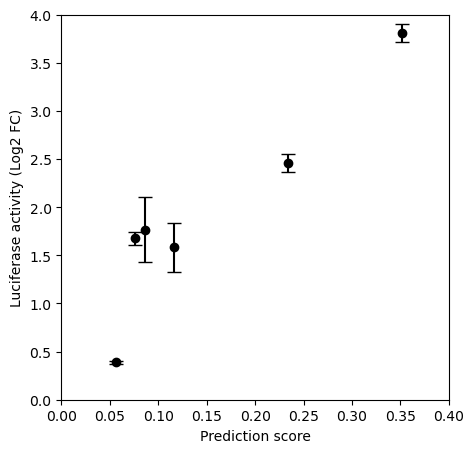

In [7]:
plt.figure(figsize=(5,5))
mean = np.mean(np.log2(rescue_dict["values"]),axis=1)
std = np.std(np.log2(rescue_dict["values"]),axis=1)

plt.errorbar(rescue_dict["prediction_deepmel"][:,3][0:6],mean[0:6],yerr=std[0:6],linestyle="None", color="black",fmt="o",capsize=5)
plt.ylim(0,4)
plt.xlim(0,0.4)
plt.ylabel("Luciferase activity (Log2 FC)")
plt.xlabel("Prediction score")

plt.savefig("figures/enhance_rescue/rescue_prediction_vs_luciferase.pdf",transparent=True,dpi=300)


### Plotting nucleotide contribution scores together with in silico saturation mutagenesis values

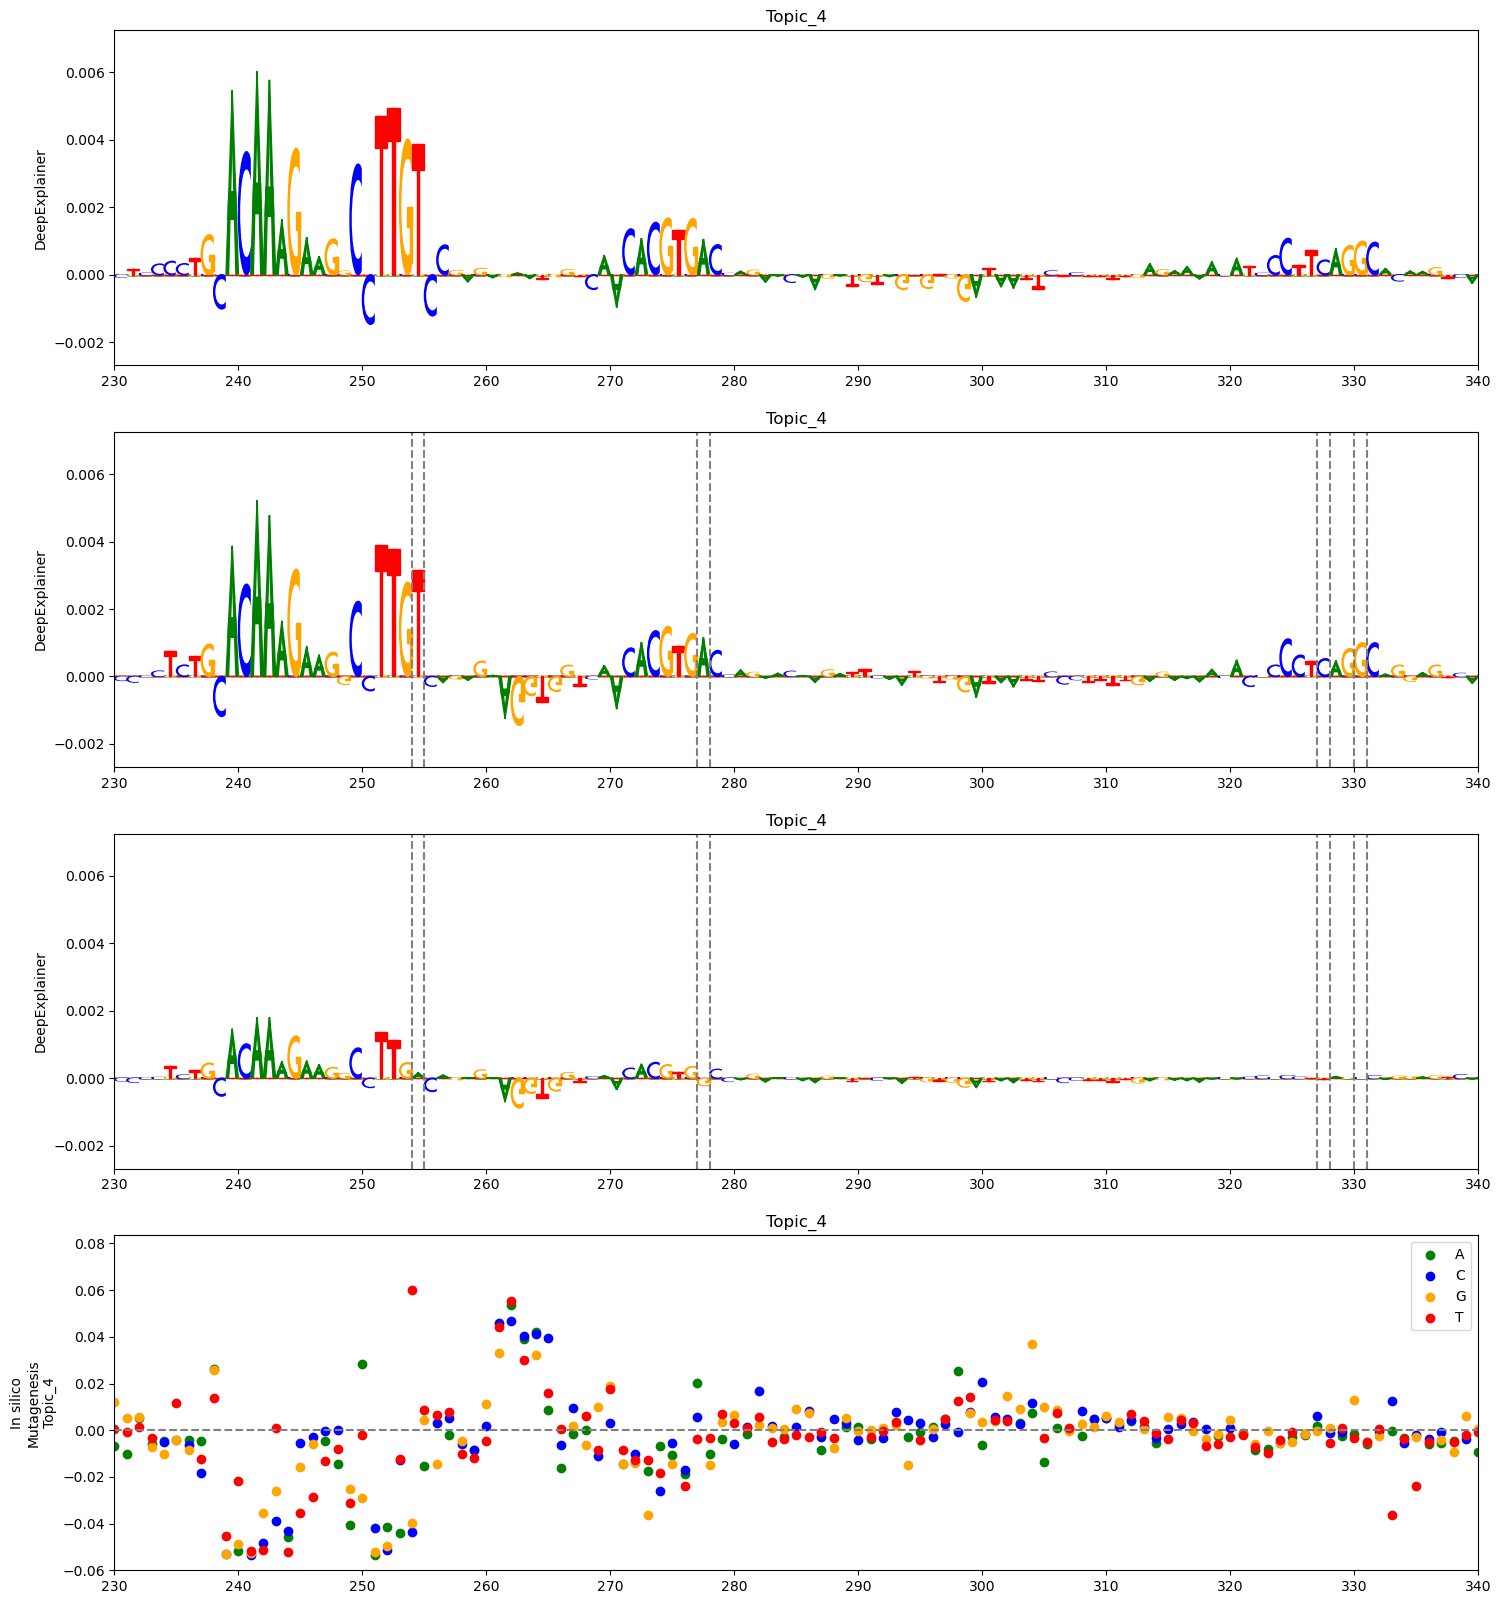

In [8]:
st = 230
end = 340

ntrack = 4
fig = plt.figure(figsize=(17.6,ntrack*5))

start_x = np.copy(rescue_dict["X"][0:1])
ax1 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 4)
start_x = np.copy(rescue_dict["X"][5:6])
ax2 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 4)
start_x = np.copy(rescue_dict["X"][1:2])
ax3 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=start_x, class_no = 4)
ax4 = utils.plot_mutagenesis_givenax_fast_withrc(model=model_dict["deepmel"], fig=fig, ntrack=ntrack, track_no=4, seq_onehot=start_x, class_no = 4)


for i, mut_ in enumerate(["254_","277_","327_","330_"]):
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
ax3.set_xlim([st,end])
ax4.set_xlim([st,end])

min_ = np.min([ax1.get_ylim()[0],ax2.get_ylim()[0],ax3.get_ylim()[0] ])
max_ = np.max([ax1.get_ylim()[1],ax2.get_ylim()[1],ax3.get_ylim()[1] ])
ax1.set_ylim([min_, max_])
ax2.set_ylim([min_, max_])
ax3.set_ylim([min_, max_])

plt.savefig("figures/enhance_rescue/rescue_deepexplainer_humMut0_humMut4_dog_st230_end340.pdf",transparent=True)


### Plotting luciferase values versus prediction scores for the activity-enhanced sequence

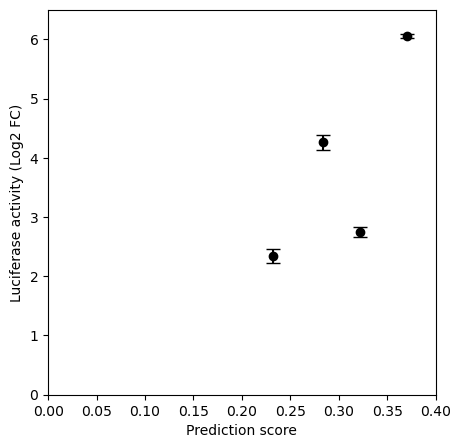

In [9]:
plt.figure(figsize=(5,5))
mean = np.mean(np.log2(rescue_dict["values"]),axis=1)
std = np.std(np.log2(rescue_dict["values"]),axis=1)

plt.errorbar(rescue_dict["prediction_deepmel"][:,3][[6,7,8,9]],mean[[6,7,8,9]],yerr=std[[6,7,8,9]],linestyle="None", color="black",fmt="o",capsize=5)
plt.ylim(0,6.5)
plt.xlim(0,0.4)
plt.ylabel("Luciferase activity (Log2 FC)")
plt.xlabel("Prediction score")

plt.savefig("figures/enhance_rescue/enhance_prediction_vs_luciferase.pdf",transparent=True)


### Plotting nucleotide contribution scores together with in silico saturation mutagenesis values

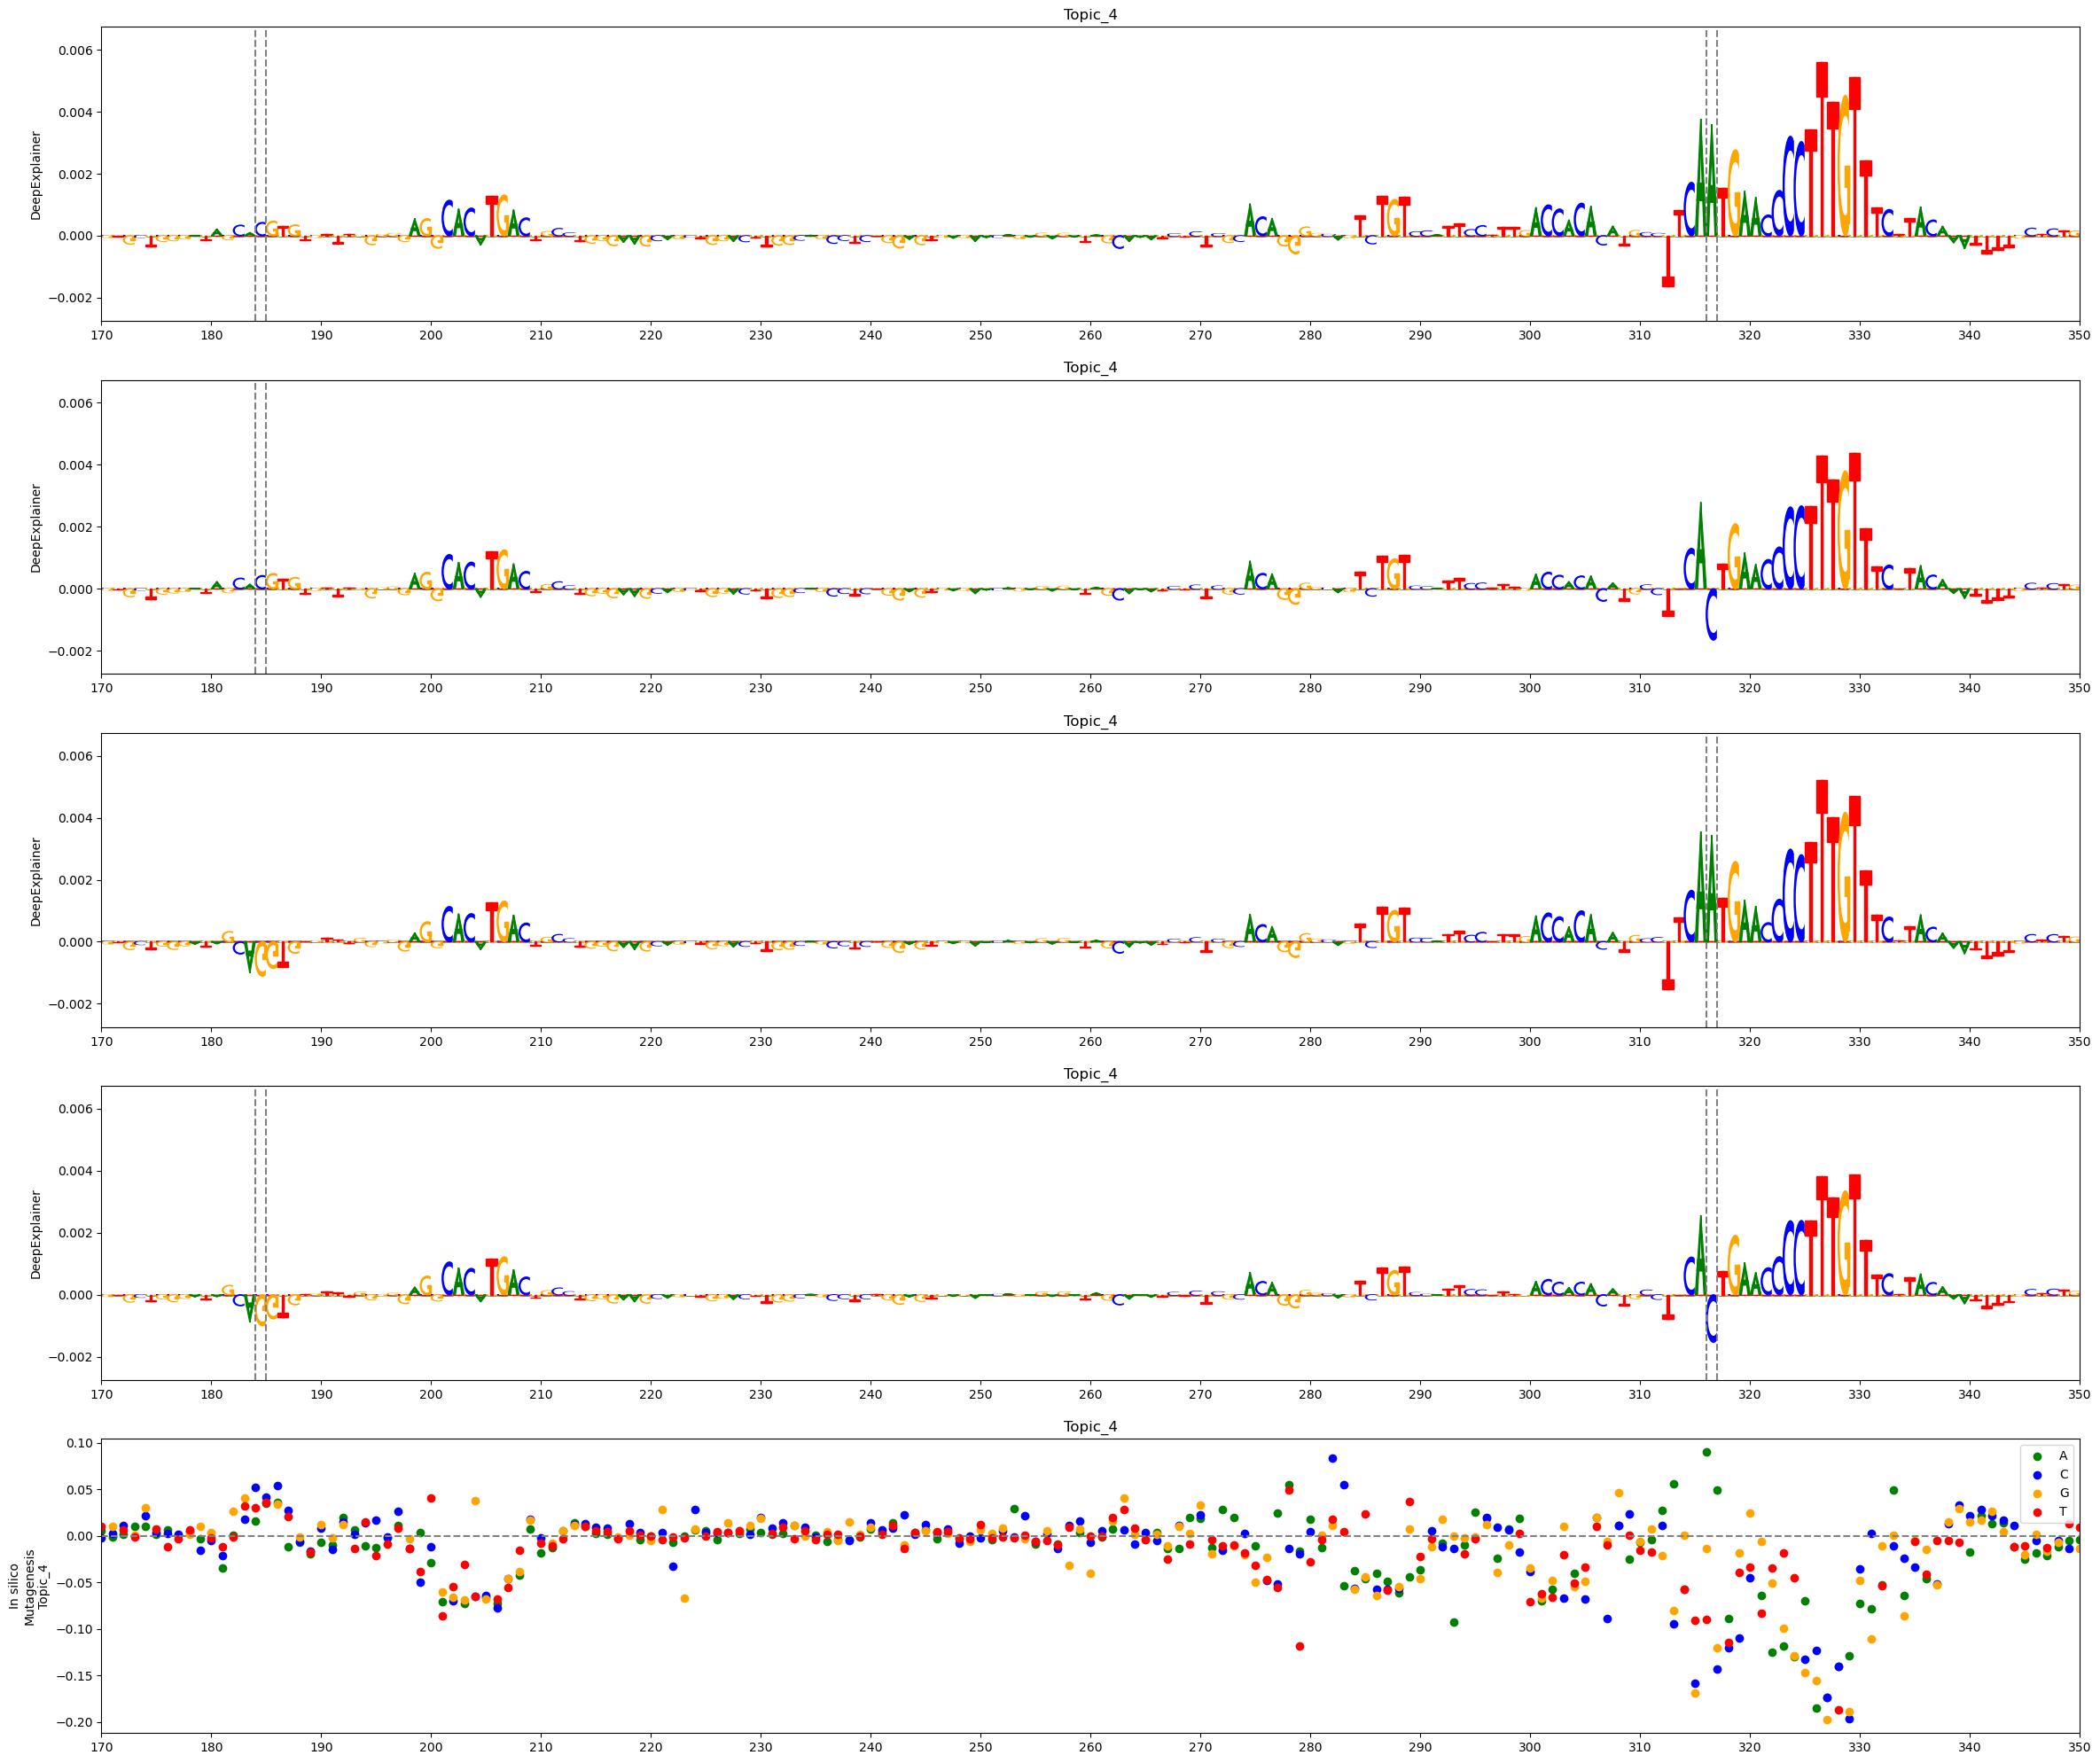

In [10]:
st = 170
end = 350

ntrack = 5
fig = plt.figure(figsize=(28.8,ntrack*5))

start_x = np.copy(rescue_dict["X"][9:10])
ax1 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 4)
start_x = np.copy(rescue_dict["X"][7:8])
ax2 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 4)
start_x = np.copy(rescue_dict["X"][8:9])
ax3 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=start_x, class_no = 4)
start_x = np.copy(rescue_dict["X"][6:7])
ax4 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel"], fig=fig, ntrack=ntrack, track_no=4, seq_onehot=start_x, class_no = 4)
ax5 = utils.plot_mutagenesis_givenax_fast_withrc(model=model_dict["deepmel"], fig=fig, ntrack=ntrack, track_no=5, seq_onehot=start_x, class_no = 4)

for i, mut_ in enumerate(["316_","184_"]):
    ax1.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax1.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax4.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax4.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
for i, mut_ in enumerate(["184_"]):
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
for i, mut_ in enumerate(["316_"]):
    ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
ax3.set_xlim([st,end])
ax4.set_xlim([st,end])
ax5.set_xlim([st,end])

min_ = np.min([ax1.get_ylim()[0],ax2.get_ylim()[0],ax3.get_ylim()[0],ax4.get_ylim()[0] ])
max_ = np.max([ax1.get_ylim()[1],ax2.get_ylim()[1],ax3.get_ylim()[1],ax4.get_ylim()[1] ])
ax1.set_ylim([min_, max_])
ax2.set_ylim([min_, max_])
ax3.set_ylim([min_, max_])
ax4.set_ylim([min_, max_])

plt.savefig("figures/enhance_rescue/enhance_deepexplainer_dogwt_dogSox_dogMitf_dogAll_st170_end350.pdf",transparent=True)
